# Example: Deep structural causal model counterfactuals

In [1]:
from typing import Dict, List, Optional, Tuple, Union, TypeVar

import torch
from torch.utils.data import DataLoader

import pyro
import pyro.distributions as dist
from pyro.poutine import condition, reparam
from pyro.nn import PyroParam, PyroSample, PyroModule
import pyro.distributions.transforms as Transforms
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDelta
from pyro.infer import config_enumerate
from pyro.distributions import constraints


import causal_pyro
from causal_pyro.query.do_messenger import do
from causal_pyro.counterfactual.handlers import Factual, MultiWorldCounterfactual, TwinWorldCounterfactual

import pandas as pd
import skimage
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt

/home/archana/anaconda3/envs/deepscm/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
available = torch.cuda.is_available()
curr_device = torch.cuda.current_device()
device = torch.device("cuda:0" if available else "cpu")
device_count = torch.cuda.device_count() 
device_name =  torch.cuda.get_device_name(0)

print(f'Cuda available: {available}')
print(f'Current device: {curr_device}')
print(f'Device: {device}')
print(f'Device count: {device_count}')
print(f'Device name: {device_name}')

Cuda available: True
Current device: 0
Device: cuda:0
Device count: 1
Device name: NVIDIA GeForce RTX 3090


## Background: Normalizing flows and counterfactuals

Much of the causal inference literature has focused on relatively simple
causal models with low dimensional data. In order to perform
counterfactual reasoning in more complex domains with high dimensional
data, Palowski et al. [@pawlowski2020deep] introduced *deep structural
causal models* (Deep SCMs): SCMs with neural networks as the functional
mechanisms between variables.

Specifically, the neural networks are
*normalizing flows*. A normalizing flow transforms a base probability
distribution (often a simple distribution, such as a multivariate
Gaussian) through a sequence of invertible transformations into a more
complex distribution (such as a distribution over images). When used
within a Deep SCM, the flow's base distribution is an exogenous noise
variable, and its output is an endogenous variable.

A salient property
of normalizing flows is that computing the likelihood of data can be
done both exactly and efficiently, and hence training a flow to model a
data distribution through maximum likelihood is straightforward. In
addition, the inverse of a normalizing flow can also typically be
efficiently computed, which renders the abduction step of a
counterfactual---inferring the posterior over exogenous variables given
evidence---trivial.

## Example: Morpho-MNIST

We consider a synthetic dataset based on MNIST, where the image of each digit ($X$) depends on stroke thickness ($T$) and brightness ($I$) of the image and the thickness depends on brightness as well.

We assume we know full causal structure (i.e., there are no unconfounded variables).

In [3]:
def load_idx(path: str) -> np.ndarray:
    """Reads an array in IDX format from disk.
    Parameters
    ----------
    path : str
        Path of the input file. Will uncompress with `gzip` if path ends in '.gz'.
    Returns
    -------
    np.ndarray
        Output array of dtype ``uint8``.
    References
    ----------
    http://yann.lecun.com/exdb/mnist/
    """
    open_fcn = gzip.open if path.endswith('.gz') else open
    with open_fcn(path, 'rb') as f:
        idx_dtype, ndim = struct.unpack('BBBB', f.read(4))[2:]
        shape = struct.unpack('>' + 'I' * ndim, f.read(4 * ndim))
        buffer_length = int(np.prod(shape))
        data = np.frombuffer(f.read(buffer_length), dtype=np.uint8).reshape(shape).astype(np.float32)
        return data
    
path = os.path.join(os.getcwd(), "../datasets/morphomnist_num_5/")
metrics = pd.read_csv(path + "train-morpho.csv", index_col= 'index')
# raw_labels = load_idx(path+"train-labels-idx1-ubyte.gz")
raw_images = load_idx(path+"train-images-idx3-ubyte.gz")

thickness = torch.tensor(metrics["thickness"], dtype=torch.float32)
intensity = torch.tensor(metrics["intensity"], dtype=torch.float32)
# labels = torch.tensor(raw_labels, dtype=torch.float32)

(-0.5, 27.5, 27.5, -0.5)

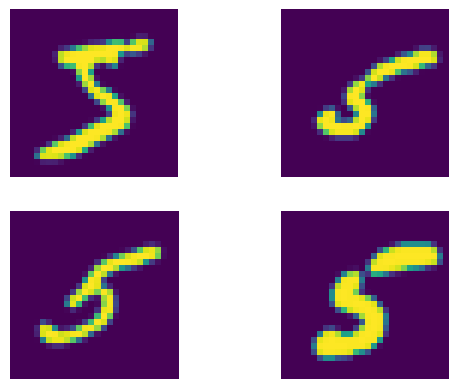

In [4]:
fig = plt.figure()
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(raw_images[0])
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(raw_images[1])
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(raw_images[2])
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(raw_images[3])
plt.axis('off')

### Downsampling images:

In [5]:
images = skimage.measure.block_reduce(raw_images, block_size=(1, 2, 2))
images = torch.tensor(images, dtype=torch.float32)
im_size = images.shape[1]
# im_size = torch.tensor(im_size)
im_size

14

(-0.5, 13.5, 13.5, -0.5)

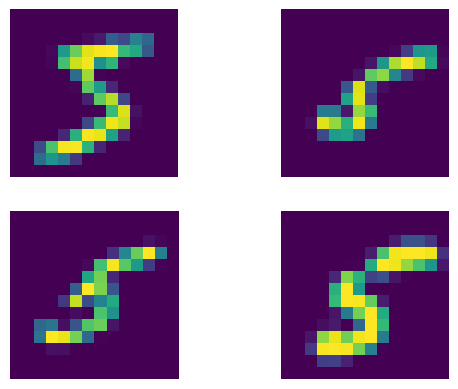

In [6]:
fig = plt.figure()
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(images[0])
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(images[1])
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(images[2])
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(images[3])
plt.axis('off')

## Model: deep structural causal model

The following code models morphological transformations of MNIST,
defining a causal generative model over digits that contains endogenous
variables to control the width $t$ and intensity $i$ of the stroke:

In [7]:
params = {"intensity_flow_bias": intensity.min(),
"intensity_flow_weight": (intensity.max() - intensity.min()),
"thickness_flow_bias": thickness.log().mean(),
"thickness_flow_weight": thickness.log().std()}

In [8]:
class DeepSCM(PyroModule):
    def __init__(self):
        super().__init__()
        
        # Thickness parameters
        thickness_param = Transforms.Spline(1)
        thickness_param.domain = constraints.positive
        self.thickness_param = thickness_param
        
        # Intensity parameters
        intensity_net = pyro.nn.ConditionalAutoRegressiveNN(1, 1, hidden_dims=[10], nonlinearity=torch.nn.Identity())
        intensity_param = Transforms.ConditionalAffineAutoregressive(intensity_net)
        intensity_param.codomain = constraints.positive
        self.intensity_param = intensity_param
        
        # Image parameters
        input_dim = im_size*im_size
        nn_f_X = pyro.nn.ConditionalAutoRegressiveNN(input_dim, 2, [10*input_dim], nonlinearity=torch.nn.Identity())
        f_X = Transforms.ConditionalAffineAutoregressive(nn_f_X, log_scale_min_clip=-1., log_scale_max_clip=5.)
        f_X.domain = constraints.positive
        self.f_X = f_X
        norm = Transforms.BatchNorm(input_dim, momentum=0.05)
        self.norm = norm
        split_dim = input_dim // 5
        param_dims = [input_dim-split_dim, input_dim-split_dim]
        auto_nn_0 = pyro.nn.AutoRegressiveNN(input_dim, [10*input_dim], nonlinearity=torch.nn.Identity())
        img_affine_coupling = Transforms.AffineAutoregressive(auto_nn_0, log_scale_min_clip=-1., log_scale_max_clip=5.)
#         nn_affine_coupling = pyro.nn.DenseNN(split_dim, [10*input_dim], param_dims, nonlinearity=torch.nn.Identity())
#         img_affine_coupling = Transforms.AffineCoupling(split_dim, nn_affine_coupling, log_scale_min_clip=-1., log_scale_max_clip=5.0)
        self.img_affine_coupling = img_affine_coupling
        norm_2 = Transforms.BatchNorm(input_dim, momentum=0.05)
        self.norm_2 = norm_2
#         auto_nn = pyro.nn.AutoRegressiveNN(input_dim, [10*input_dim], nonlinearity=torch.nn.Identity())
#         img_auto = Transforms.AffineAutoregressive(auto_nn, log_scale_min_clip=-1., log_scale_max_clip=5.)
        nn_affine_coupling_2 = pyro.nn.DenseNN(split_dim, [10*input_dim], param_dims, nonlinearity=torch.nn.Identity())
        img_auto = Transforms.AffineCoupling(split_dim, nn_affine_coupling_2, log_scale_min_clip=-1., log_scale_max_clip=5.0)
        self.img_auto = img_auto
    
    def forward(self):
        # Thickness:
        UT = dist.Normal(0, 1).expand([1]).to_event(1)
        thickness_flow_loc = params["thickness_flow_bias"]
        thickness_flow_scale = params["thickness_flow_weight"]
        thickness_flow_lognorm = Transforms.AffineTransform(loc=thickness_flow_loc, scale=thickness_flow_scale)
        t_transforms = [
            self.thickness_param,
            thickness_flow_lognorm,
            Transforms.ExpTransform()
        ]
        T = pyro.sample("T", dist.TransformedDistribution(UT, t_transforms))
        
        # Intensity:
        UI = dist.Normal(0, 1).expand([1]).to_event(1)
        intensity_flow_loc = params["intensity_flow_bias"]
        intensity_flow_scale = params["intensity_flow_weight"]
        intensity_flow_norm = Transforms.AffineTransform(loc=intensity_flow_loc, scale=intensity_flow_scale)
        intensity_tranforms = [
            self.intensity_param,
            Transforms.SigmoidTransform(), 
            intensity_flow_norm
        ]
#         T = T.expand(torch.broadcast_shapes(T.shape[:-1]) + T.shape[-1:])
        I_ = dist.ConditionalTransformedDistribution(UI, intensity_tranforms)
        I = I_.condition(context=T)
        I = pyro.sample("I", I)

        
        # Image:
        UX = dist.Normal(0, 1).expand([im_size*im_size]).to_event(1)
        
        # Preprocessing
        alpha = 0.001
        num_bits = 2
        s = Transforms.SigmoidTransform()
        preprocess_transform = Transforms.ComposeTransform([
#             Transforms.AffineTransform(0., (1. / 2 ** num_bits)),
#             Transforms.AffineTransform(alpha, (1 - alpha)),
            s.inv
        ])
    
        batch_shape = torch.broadcast_shapes(T.shape[:-1], I.shape[:-1])
        T = T.expand(batch_shape + T.shape[-1:])
        I = I.expand(batch_shape + I.shape[-1:])
        
        assert T.shape == I.shape
        
        f_X = self.f_X.condition(context=torch.cat((T, I), dim=-1))
        
#         assert torch.cat((T, I), dim=-1).shape == (2, )
        
        h_X = dist.TransformedDistribution(UX, [preprocess_transform,
                                               f_X,
                                               self.norm,
                                               self.img_affine_coupling,
                                               self.norm_2,
                                               self.img_auto])
        X = pyro.sample("X", h_X)
        return X

/home/archana/anaconda3/envs/deepscm/lib/python3.11/site-packages/pyro/nn/auto_reg_nn.py:179: UserWarning: ConditionalAutoRegressiveNN input_dim = 1. Consider using an affine transformation instead.
  warnings.warn(


['thickness_param.unnormalized_widths', 'thickness_param.unnormalized_heights', 'thickness_param.unnormalized_derivatives', 'thickness_param.unnormalized_lambdas', 'intensity_param.nn.layers.0.weight', 'intensity_param.nn.layers.0.bias', 'intensity_param.nn.layers.1.weight', 'intensity_param.nn.layers.1.bias', 'f_X.nn.layers.0.weight', 'f_X.nn.layers.0.bias', 'f_X.nn.layers.1.weight', 'f_X.nn.layers.1.bias', 'norm.gamma', 'norm.beta', 'img_affine_coupling.arn.layers.0.weight', 'img_affine_coupling.arn.layers.0.bias', 'img_affine_coupling.arn.layers.1.weight', 'img_affine_coupling.arn.layers.1.bias', 'norm_2.gamma', 'norm_2.beta', 'img_auto.nn.layers.0.weight', 'img_auto.nn.layers.0.bias', 'img_auto.nn.layers.1.weight', 'img_auto.nn.layers.1.bias']


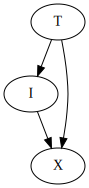

In [9]:
scm = DeepSCM()
print(list(dict(scm.named_parameters()).keys()))
# print(pyro.poutine.trace(scm).get_trace().log_prob_sum())
pyro.render_model(scm)

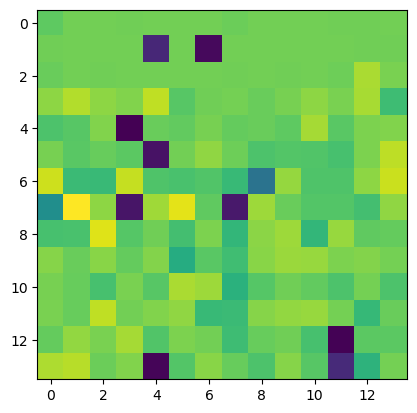

In [10]:
plt.imshow(scm().detach().reshape((im_size, im_size)))

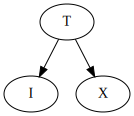

In [11]:
intervened_scm = do(scm, {"I": torch.randn(1)})
pyro.render_model(intervened_scm)

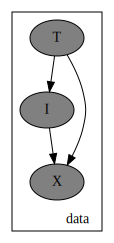

In [12]:
def conditioned_scm(model):
    def query_model(t_obs, i_obs, x_obs):
        with pyro.condition(data={"X": x_obs, "T": t_obs, "I": i_obs}), \
                pyro.plate("data", size=x_obs.shape[0], dim=-1):
            return model()
    return query_model

conditioned_model = conditioned_scm(scm)
imgs = conditioned_model(thickness[:3, None], intensity[:3, None], images[:3].reshape(-1, im_size*im_size))
pyro.render_model(conditioned_model, model_args=(thickness[:2][..., None], intensity[:2][..., None], images[:2].reshape(-1, im_size*im_size)))

In [13]:
initial_lr = 0.0001
gamma = 0.8
num_iterations = 20
lrd = gamma ** (1 / num_iterations)
adam_params = {"lr": initial_lr, "betas": (0.95, 0.999), "lrd":lrd}
optimizer = pyro.optim.ClippedAdam(adam_params)
empty_guide = lambda *args: None
svi = SVI(conditioned_model, empty_guide, optimizer, loss=pyro.infer.TraceMeanField_ELBO(num_particles=10, vectorize_particles=True))
predictive = pyro.infer.Predictive(scm, guide=empty_guide, num_samples=32)
dataset = [(thickness[i], intensity[i], images[i]) for i in range(images.shape[0])]

pyro.clear_param_store()
for j in range(num_iterations):
    data = iter(DataLoader(dataset, batch_size=150, shuffle=True))
    print(f"Iteration: {j + 1}\n---------")
    for i in range(len(data)):
        t_obs, i_obs, x_obs = next(data)
        loss = svi.step(t_obs[..., None], i_obs[..., None], x_obs.reshape(-1, im_size*im_size))
        if i%10 == 0:
            print(loss)
    print("\n")

Iteration: 1
---------
281608.0
201841.75
181876.9875
180569.3625


Iteration: 2
---------
168922.8125
174039.3375
165995.375
148650.575


Iteration: 3
---------
151385.025
132937.675
139128.4125
130853.075


Iteration: 4
---------
140052.65
136795.6875
130406.2
140227.8625


Iteration: 5
---------
134872.5
127503.2375
137076.6375
119931.7875


Iteration: 6
---------
126934.9625
116086.4625
122533.1125
124418.5375


Iteration: 7
---------
121381.6875
125566.9375
118638.1125
122669.2625


Iteration: 8
---------
125326.725
129149.025
109063.3625
134741.4


Iteration: 9
---------
120342.375
118471.125
116145.9875
129356.7625


Iteration: 10
---------
115769.1625
109889.3
127628.25
113660.95


Iteration: 11
---------
119813.1375
122154.925
125866.775
126627.4375


Iteration: 12
---------
123224.0875
119530.675
117791.0875
122063.4625


Iteration: 13
---------
117752.6125
118988.6625
118829.725
127640.125


Iteration: 14
---------
121662.625
127242.4375
116273.05
114581.55


Iteration: 15
-

In [14]:
img = predictive()["X"]

(-0.5, 13.5, 13.5, -0.5)

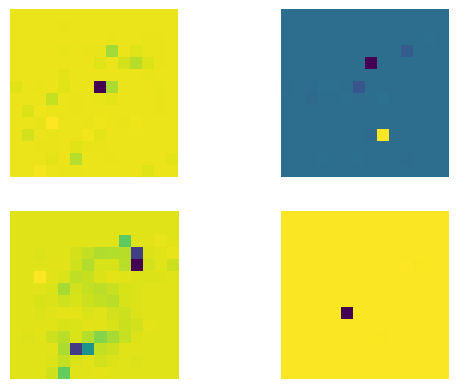

In [15]:
fig = plt.figure()
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(img[0].reshape((im_size, im_size)))
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(img[1].reshape((im_size, im_size)))
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(img[2].reshape((im_size, im_size)))
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(img[3].reshape((im_size, im_size)))
plt.axis('off')

## Query: counterfactual data generation

Next we ask a *counterfactual* question: given an observed digit $X$, what
would the digit have been had $t$ been $t + 1$?

To compute this quantity we would normally:
   1. invert the model to find latent exogenous noise $u$
   2. construct an intervened model
   3. re-simulate the forward model on the $u$ [@pearl2011algorithmization].  

However, we can equivalently
represent this process with inference in a single, expanded
probabilistic program containing two copies of every deterministic
statement (a so-called \"twin network\" representation of
counterfactuals, first described in Chapter 7 of [@pearl] and extended
to the PPL setting in [@tavares_2020])

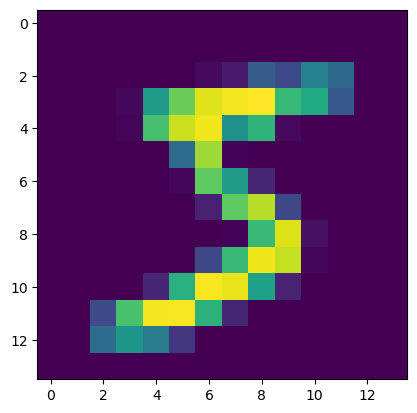

In [16]:
x_obs = images[0]
plt.imshow(x_obs.detach().reshape((im_size, im_size)))

In [17]:
def deep_scm_query(model : DeepSCM):
    def query_model(x_obs):
        with TwinWorldCounterfactual(dim=-1), \
        do(actions={'I': torch.tensor([190.0])}), \
            condition(data={"X": x_obs.reshape(-1, im_size*im_size)}):
                return model()
    return query_model

cf_model = deep_scm_query(predictive)

(-0.5, 13.5, 13.5, -0.5)

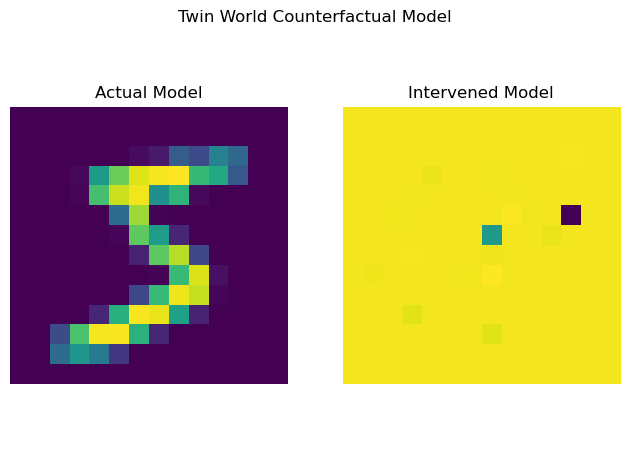

In [18]:
fig = plt.figure()
plt.title("Twin World Counterfactual Model")
plt.axis("off")
plt.tight_layout()
rows = 1
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(cf_model(x_obs)["X"][0][0].reshape((14, 14)))
plt.title("Actual Model")
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(cf_model(x_obs)["X"][0][1].reshape((14, 14)))
plt.title("Intervened Model")
plt.axis('off')

Like all counterfactuals, this estimand is not identified in general
without further assumptions: learning parameters $\theta$ that match
observed data does not guarantee that the counterfactual distribution
will match that of the true causal model. 

However, as discussed in the
original paper [@pawlowski2020deep] in the context of modeling MRI
images, there are a number of valid practical reasons one might wish to
compute it anyway, such as explanation or expert evaluation.